In [2]:
import imageio as iio
import math

from skimage import filters
from skimage.color import rgb2gray
from skimage.measure import regionprops
from skimage.morphology import convex_hull_image
from skimage import data, img_as_float
from skimage.util import invert
from skimage import feature
from skimage.filters import gaussian
from skimage.segmentation import active_contour

import skimage

from ezdxf.addons.drawing.properties import LayoutProperties
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend

from scipy import ndimage
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import ezdxf

from numba import jit
import timeit

In [3]:
def regressive_polyimg_to_dxf_multi_spline(img, msp, poly_scalar=1, s_foreground_thresh=160, alpha=0.05, beta=15, gamma=0.035, gaussian_sigma=3, preview=False, pass_bool=None):
    im_gray = np.array(img.convert('L'))
    im_gray_thresh = im_gray.copy()
    im_gray_thresh[im_gray_thresh < s_foreground_thresh] = 0
    im_bool = im_gray < s_foreground_thresh
    
    if pass_bool is not None:
        im_bool = pass_bool
   
    im_bin = im_bool.astype(np.uint8)

    labels, num = skimage.morphology.label(im_bin, background=None, return_num=True, connectivity=2)
    
    splinelst = []
    
    for l_num in range(1, num + 1):
        tr_arr = (labels == l_num) * 1.
        tr_bool = np.invert(ndimage.binary_fill_holes(labels == l_num))
        
        convimg = convex_hull_image(tr_arr)
        cent_pt = ndimage.measurements.center_of_mass(tr_arr)
        cent_conv_pt = np.array(ndimage.measurements.center_of_mass(convimg))
        
        edges = feature.canny(convimg, sigma=gaussian_sigma)
        
        indices = np.where(edges == [1])
        coordinates = [list(a) for a in zip(indices[0], indices[1])]
        coordinates.sort(key=lambda p: math.atan2(p[1]-cent_pt[1],p[0]-cent_pt[0]))
    
        init = (coordinates - cent_conv_pt) * poly_scalar + cent_conv_pt
        
        snake = active_contour(
            gaussian(im_gray_thresh, sigma=gaussian_sigma, preserve_range=False),
            init,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
        )
        
        tr_inside = tr_arr.copy()
        tr_inside[tr_bool] = invert(tr_inside[tr_bool])
        tr_inside = invert(tr_inside)
        
        if preview:
            fig, ax = plt.subplots(1, 2, figsize=(16, 8))
            
            ax[1].imshow(tr_inside, cmap=plt.cm.gray)
            
            ax[0].imshow(im_bin, cmap=plt.cm.gray)
            ax[0].plot(init[:, 1], init[:, 0], '--r', lw=3)
            ax[0].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
            ax[0].scatter([cent_pt[1]], [cent_pt[0]])
            ax[0].set_xticks([]), ax[0].set_yticks([])
            ax[0].axis([0, im_gray_thresh.shape[1], im_gray_thresh.shape[0], 0])
            
            plt.show()
            
        fit_points = [(ptt[1], ptt[0], 0) for ptt in snake] + [(snake[0][1], snake[0][0], 0)]
        splinelst.append(msp.add_spline(fit_points))
        
        regressive_polyimg_to_dxf_multi_spline(img, msp, poly_scalar=poly_scalar, s_foreground_thresh=s_foreground_thresh, alpha=alpha, beta=beta, gamma=gamma, gaussian_sigma=gaussian_sigma, preview=preview, pass_bool=tr_inside.astype(bool))
    
    return splinelst

# Test the function
def loaderDXF():
    demo_img = Image.open("old_stuff/demo3.jpg")
    
    doc = ezdxf.new("R2000")
    msp = doc.modelspace()
    
    splist = regressive_polyimg_to_dxf_multi_spline(demo_img, msp, 
                                                    poly_scalar=1, 
                                                    s_foreground_thresh=160, 
                                                    alpha=0.03, # 0.03 
                                                    beta=0.25, # 0.25
                                                    gamma=0.035, 
                                                    gaussian_sigma=3,
                                                    preview=False)
    
    fig = plt.figure()
    ax = fig.add_axes((0, 0, 1, 1))
    
    ctx = RenderContext(doc)
    
    # get the modelspace properties
    msp_properties = LayoutProperties.from_layout(msp)
    
    # set light gray background color and black foreground color
    msp_properties.set_colors("#eaeaea")
    out = MatplotlibBackend(ax)
    
    # override the layout properties and render the modelspace
    Frontend(ctx, out).draw_layout(
        msp,
        finalize=True,
        layout_properties=msp_properties,
    )
    
    #fig.savefig("export.png")
    doc.saveas("full.dxf")

print("time: ", timeit.timeit(lambda: loaderDXF(), number=1))


/var/folders/t8/4l7cl3f50bxf2hs1wf7rbgjm0000gp/T/ipykernel_3627/1817607318.py:21: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  cent_pt = ndimage.measurements.center_of_mass(tr_arr)
/var/folders/t8/4l7cl3f50bxf2hs1wf7rbgjm0000gp/T/ipykernel_3627/1817607318.py:22: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  cent_conv_pt = np.array(ndimage.measurements.center_of_mass(convimg))


KeyboardInterrupt: 

TypeError: Input z must be 2D, not 3D

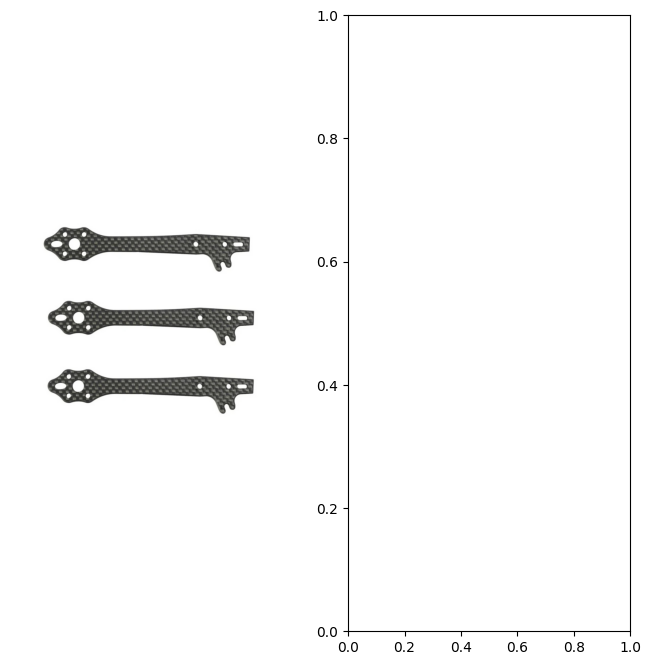

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import (
    morphological_chan_vese,
    morphological_geodesic_active_contour,
    inverse_gaussian_gradient,
    checkerboard_level_set,
)

# Morphological GAC
image = img_as_float(Image.open("old_stuff/demo3.jpg"))
gimage = inverse_gaussian_gradient(image)

# Initial level set
init_ls = np.zeros(image.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1

# List with intermediate results for plotting the evolution
evolution = []

def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

callback = store_evolution_in(evolution)
ls = morphological_geodesic_active_contour(
    gimage,
    num_iter=230,
    init_level_set=init_ls,
    smoothing=1,
    balloon=-1,
    threshold=0.69,
    iter_callback=callback,
)

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological GAC segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[1].contour(evolution[100], [0.5], colors='y')
contour.collections[0].set_label("Iteration 100")
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 230")
ax[1].legend(loc="upper right")
title = "Morphological GAC evolution"
ax[1].set_title(title, fontsize=12)

fig.tight_layout()
plt.show()